In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators
from pyiga import algebra_cy

from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [114]:
class IetiMapper:
    def __init__(self, M, dir_data, neu_data=None, elim=False):
        self.mesh = M
        self.numpatches = self.mesh.numpatches
        self.elim=bool(elim)

        self.intfs = set()
        self.L_intfs = {}

        #self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        self.numdofs = self.N_ofs[-1]

        for ((p1,bd1,s1),((p2,bd2,s2),flip)) in self.mesh.interfaces.items():
            if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
                
        for (p,b,_),(p2,b2,_),_ in self.intfs:
            if (p,b) not in self.L_intfs:
                self.L_intfs[(p,b)]=[(p2,b2)]
            else:
                self.L_intfs[(p,b)].append((p2,b2))

        C=[self.join_boundaries(p1, (assemble.int_to_bdspec(bd1),), s1 , p2, (assemble.int_to_bdspec(bd2),), s2, flip) for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs.copy()]
        if len(C)!=0:
            self.B = scipy.sparse.vstack(C)

        #self.B = self.parametersort(self.B, a)

        kvs = self.mesh.kvs
        geos = self.mesh.geos

        self.dir_idx = dict()
        self.dir_vals = dict()
        self.free = [np.arange(self.N[p]) for p in range(self.numpatches)]

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            self.free[p] = np.setdiff1d(self.free[p],self.dir_idx[p],assume_unique=True)
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.global_free = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx, assume_unique=True)

        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+self.N_ofs[p] for p, kvs in enumerate(self.mesh.kvs)])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.intfs], dtype=np.int32).T
        #     Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=10)
        #     self.Basis, self.N_ofs, self.N, B = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis.tocsc(), self.N_ofs.astype(np.int32), p_intfs)
        
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        nnz_per_col = self.B.getnnz(axis=0)
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.interior = np.setdiff1d(np.where(nnz_per_col == 0)[0], self.global_dir_idx)

        # nS = len(self.skeleton)
        # nI = len(self.interior)
        # self.R_skeleton = [(scipy.sparse.coo_matrix((np.ones(nS),(np.arange(nS),self.skeleton[])),(nS, self.N_ofs[-1])).tocsc())[:,self.N_ofs[p] + self.free[p]] 
        #                    for p in range(self.numpatches)]
        
        self.R_interior = self.numpatches*[None] ###TODO: without loops
        self.R_skeleton = self.numpatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior,:][:,self.free[p]]
            for b in range(4):
                if not any([(p,b) in self.mesh.outer_boundaries[key] for key in self.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf,:][:,self.free[p]]
            self.R_skeleton[p] = Id[mask_skeleton,:][:,self.free[p]]

        # self.N -= np.array([len(self.dir_idx[p]) if p in self.dir_idx else 0 for p in range(self.numpatches)])
        # self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # self.B = self.B[:,self.global_free]
        # self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        
    def assemble(self, a, f):
        if self.elim:
            A = [self.Basis.T @ assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) @ self.Basis for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [self.Basis.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        else:
            A = [assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(A[p], RHS[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        RHS = [rhs if p not in self.dir_idx else self.BCRestr[p].b for p, rhs in enumerate(RHS)]
        A = [Ak if p not in self.dir_idx else self.BCRestr[p].A for p, a in enumerate(A)]

        return A, RHS

    def ConstraintMatrices(self, redundant = False):
        keep = None
        if not redundant:
            eliminate_constr = (self.B[:,self.corners].getnnz(1)==2)
            B = self.B[~eliminate_constr,:]
            # corner_idx = np.ones(self.numdofs) 
            # corner_idx[self.corners]=0
            # Q = scipy.sparse.spdiags(corner_idx, 0, self.numdofs, self.numdofs)

            # B = self.B[:,self.corners]
            # B.data[~np.isclose(abs(B.data),1)]=0
            # B.eliminate_zeros()
            # B = (self.B@Q)[B.getnnz(1)==0,:]
        else:
            B = self.B
        B = B[:,self.global_free]
        B = B[B.getnnz(1)>0,:]
        ofs = np.cumsum([0]+[len(x) for x in self.free])
        return [B[:,ofs[p]:ofs[p+1]] for p in range(self.numpatches)]

    def join_boundaries(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.sdim-1)*(False,)
        
        bkv1 = assemble.boundary_kv(kvs1, bdspec1)
        bkv2 = assemble.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = assemble.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = assemble.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            #print(p1, bkv1, p2, bkv2)
            print('Interface coupling not possible between patch '+ str(p1) +' and patch '+str(p2)+'!')    
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make parameter to generate prolongation matrix as coo_matrix directly?
        
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        A = scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.N_ofs[-1])).tocsr()
        return A
        
    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        n = self.N_ofs[-1]

        idx = (self.B[:,self.corners]>0).getnnz(1)>0
        B = self.B[idx,:]
        B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        c_B = B@R.T
        #print(c_B.toarray())

        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        #print(nodal_indicator.toarray())
        
        dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
        S = c_B.sum(0).A[0]
        for j in range(nodal_indicator.shape[1]):
            ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
            dofs[j]=R.indices[ind[np.argmax(S[ind])]]
        nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
        nnz = self.B.getnnz(1)
        B = self.B.tocsc()
        constr = np.repeat(-1,len(dofs))

        for j in range(nodal_indicator.shape[1]):
            dof=dofs[j]
            for r in range(B.indptr[dof],B.indptr[dof+1]):
                i=B.indices[r]
                if nnz[i]>2:
                    constr[j]=i
                    break

        if any(constr!=-1):
            idx = np.where(constr!=-1)[0]
            res = scipy.sparse.csc_matrix(nodal_indicator.shape)
            Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
            res = (Q@abs(self.B[constr[idx],:])).T
            res.data=res.data-1
            res.eliminate_zeros()
            res.data=res.data+1
            nodal_indicator += res

        q = np.ones(self.N_ofs[-1])
        q[self.global_dir_idx]=0
        nodal_indicator=scipy.sparse.spdiags(q,0,self.N_ofs[-1],self.N_ofs[-1])@nodal_indicator
        nodal_indicator = nodal_indicator[:,nodal_indicator.getnnz(0)>1]
        return nodal_indicator
        
    #def averages_as_primals(self):

In [115]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = np.zeros(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap):
        self.nLagrangeMultipliers = B[0].shape[0]
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        C=[]
        for p in range(K):
            c = (self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T).tocsr()
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[:,IMap.free[p]]
            c = c[c.getnnz(1)>0,:]
            C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in C]

        mod_A = [scipy.sparse.bmat([[A[p],C[p].T],[C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        mod_B = [scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS
        
    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        loc_solver=[solvers.make_solver(a, spd=False, symmetric=True) for a in mod_A]
        self.Psi = []
        Delta = []
        self.B_prim = np.zeros((self.nLagrangeMultipliers,self.nPrim))
        for p in range(len(mod_A)):
            RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
            sol = loc_solver[p]@RHS
            psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            Delta.append(delta)
            self.Psi.append(psi@self.R[p])
            self.A_prim -= self.R[p].T@delta@self.R[p]
            self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@self.Psi[-1]
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
        return loc_solver

    def distributePrimalSolution(self, u):
        u_prim = u[-1]
        return [u[p]+self.Psi[p]@u_prim for p in range(len(u)-1)]

    def PrimalSolution(self, u_prim):
        return [psi@u_prim for psi in self.Psi]
        

In [116]:
class IetiSystem():
    def __init__(self, A, B ,RHS, N, loc_solver = None, spd=False, symmetric=False):
        self.A = A
        self.B = B
        self.RHS = RHS
        self.N = N

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symmetric=symmetric) for a in self.A]

        self.sanity_check()
        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='coo'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([aslinearoperator(self.B[p])@self.loc_solver[p]@aslinearoperator(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.eye(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        return [(self.loc_solver[p]@(self.RHS[p]-self.B[p].T@lam))[:self.N[p]] for p in range(self.K)]
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [224]:
from scipy.sparse.linalg import aslinearoperator as LinOp
    
class ScaledDirichletPreconditioner():
    def __init__(self, A ,B, IMap, a=None):
        self.A = A
        self.IMap = IMap
        self.K   = len(B)

        self.B   = [B[p]@IMap.R_skeleton[p].T for p in range(len(B))]
        self.Aii = [IMap.R_interior[p]@A[p]@IMap.R_interior[p].T for p in range(IMap.numpatches)]
        self.Abb = [IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T for p in range(IMap.numpatches)]
        self.Abi = [IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T for p in range(IMap.numpatches)]

        self.D = []
        self.S = [LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T) - 
                  LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T)
                  @solvers.make_solver(IMap.R_interior[p]@A[p]@IMap.R_interior[p].T, spd=True)
                  @LinOp(IMap.R_interior[p]@A[p].T@IMap.R_skeleton[p].T) for p in range(self.K)]

    def SchurMatrices(self):
        return [s@np.eye(s.shape[0]) for s in self.S]
        
    def setupMultiplicityScaling(self):
        self.D = [scipy.sparse.diags(1/(1+b.getnnz(0)), format='csr') for b in self.B]
        
    def setupSelectionScaling(self, a):
        B = self.parametersort(self.B,a)
        for p in range(len(B)):
            B[p].eliminate_zeros()
        #idx = [1*(b.indptr[1:]-b.indptr[:-1]==1) & np.isclose(b.sum(axis=0).A[0],1) for b in B]
        #self.D=scipy.sparse.diags([idx],[0])
        self.D = [scipy.sparse.spdiags(1*((b.getnnz(0)==1) & (np.isclose(b.sum(0).A.flatten(),1))),0,b.shape[1],b.shape[1], format='csr') for b in B] 

    #def setupDeluxeScaling(self):
        #for p in len(D):
            
    def parametersort(self, B ,a):
        N_ofs = np.cumsum([0]+[b.shape[1] for b in B])
        K = len(B)
        B = scipy.sparse.hstack(B)
        a_int = {key:i for i,key in enumerate(a)}
        n=B.shape[0]
        idx = np.where(B.getnnz(1)==2)[0]
        D = np.array([a_int[key] for key in self.IMap.mesh.patch_domains.values()], dtype=int)
        I = B[idx].indices.reshape(len(idx),2)
        P = np.array([p*((N_ofs[p]<= I) & (I < N_ofs[p+1])) for p in range(K)]).sum(axis=0)
        A = np.array(list(a_int.values()))
        R = A[D[P]]*B[idx].data.reshape(len(idx),2)[:,1][:,newaxis]
        switch = idx[R[:,0]<R[:,1]]
        q = np.ones(n)
        q[switch]=-1.
        return [scipy.sparse.spdiags(q,0,n,n)@b for b in self.B]
        
    def prec(self):
        assert len(self.D)>0, 'No scaling matrices given! Call a setup routine first!'
        BgD = [LinOp(self.B[p]@self.D[p]) for p in range(self.K)]
        return operators.SumOperator([BgD[p]@self.S[p]@BgD[p].T for p in range(self.K)])
        

setting up constraints took 0.006471872329711914 seconds.
Basis setup took 0.0019898414611816406 seconds
pcg with preconditioned condition number κ ~ 4.101624546144739 stopped after 10 iterations with relres 4.0165610850411555e-07
pcg with preconditioned condition number κ ~ 3.1910544181251552 stopped after 5 iterations with relres 1.1287468100404131e-08


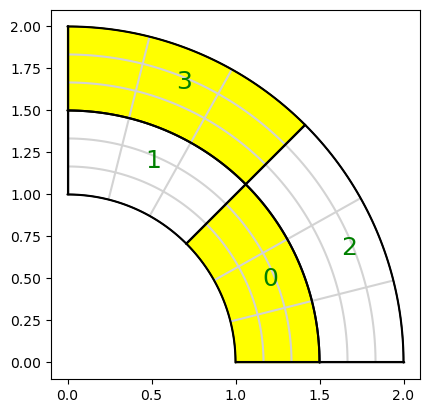

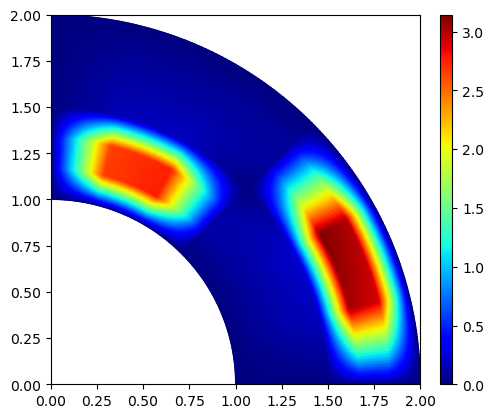

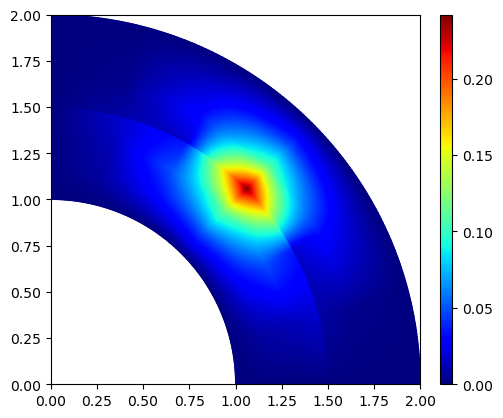

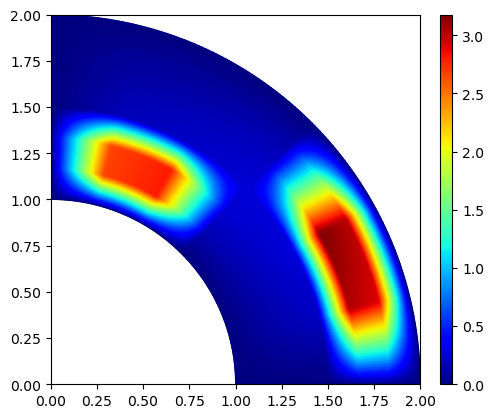

In [234]:
deg = 1
N = 3

knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.split_patch(0,axis=0);
M.split_patch(0,axis=1);
M.split_patch(1,axis=1);

M.set_domain_id({1:{0,3}})

#M.h_refine({1:-1,2:-1})
#M.h_refine({0:-1,3:-1})

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:100.}
dir_data = {0:0}

M.draw(knots=1, patch_idx=1, color={0:"white", 1:"yellow"})
MP = assemble.Multipatch(M, automatch=True)

IMap = IetiMapper(M, dir_data)
A, RHS = IMap.assemble(a,f)
N = [a.shape[0] for a in A]
B = IMap.ConstraintMatrices(redundant=True)

P = ScaledDirichletPreconditioner(A, B, IMap)

primal = PrimalSystem(IMap.nodes_as_primals())
A, B, RHS = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
loc_solver = primal.compute_PrimalBasis(A, B, RHS)
A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), 
loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

I = IetiSystem(A, B, RHS, N, loc_solver)
F, b = I.SchurComplement(), I.RHSforSchurComplement()

F_mat = F@np.eye(F.shape[0])

lam0, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

P.setupMultiplicityScaling()
lam1, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)

# P.setupSelectionScaling(a)
# lam2, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)


u_delta = I.constructSolutionFromLagrangeMultipliers(lam0)[:-1]
u_prim =primal.PrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam0)[-1])
#u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam0))

u_delta = np.concatenate([IMap.BCRestr[p].complete(u) for p,u in enumerate(u_delta)])
u_prim = np.concatenate([IMap.BCRestr[p].complete(u) for p,u in enumerate(u_prim)])
#u = np.concatenate([IMap.BCRestr[p].complete(u) for p,u in enumerate(u)])

MP.plot(u_delta)
MP.plot(u_prim)
MP.plot(u_delta+u_prim)

In [237]:
P.D[0].toarray()

array([[0.5    , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.5    , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.5    , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.5    , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.33333]])

In [20]:
IMap.L_intfs

{(0, 1): [(1, 0)], (2, 1): [(3, 0)], (1, 3): [(3, 2)], (0, 3): [(2, 2)]}

In [36]:
P.SchurMatrices()

[array([[1131.54127, -143.6089 ,  -28.62129,   17.2135 ,  -59.72121],
        [-143.6089 , 1130.74116, -140.10609, -341.64569,   42.10819],
        [ -28.62129, -140.10609, 1573.51879, -539.82274,  -48.6337 ],
        [  17.2135 , -341.64569, -539.82274, 1692.58031, -667.54008],
        [ -59.72121,   42.10819,  -48.6337 , -667.54008,  850.15219]]),
 array([[ 1.57352, -0.53982, -0.04863, -0.14011, -0.02862],
        [-0.53982,  1.69258, -0.66754, -0.34165,  0.01721],
        [-0.04863, -0.66754,  0.85015,  0.04211, -0.05972],
        [-0.14011, -0.34165,  0.04211,  1.13074, -0.14361],
        [-0.02862,  0.01721, -0.05972, -0.14361,  1.13154]]),
 array([[ 1.19756, -0.09136, -0.04982,  0.03313, -0.00418],
        [-0.09136,  1.2056 ,  0.07441, -0.29027, -0.10111],
        [-0.04982,  0.07441,  0.93011, -0.74003, -0.03489],
        [ 0.03313, -0.29027, -0.74003,  1.94929, -0.7758 ],
        [-0.00418, -0.10111, -0.03489, -0.7758 ,  2.08223]]),
 array([[ 930.10946, -740.02523,  -34.89343,

In [489]:
(P.prec()@F)@np.eye(F.shape[0])

array([[ 1.76396e+02,  3.52291e+02,  1.76139e+02, -7.37327e+00, -1.47335e+01, -7.36650e+00,  4.40950e+01,  8.81935e+01,  4.40971e+01, -6.44350e+01, -1.28871e+02, -6.44379e+01],
       [ 8.15973e+02,  1.63219e+03,  8.15937e+02, -1.33655e+01, -2.66638e+01, -1.33305e+01,  2.04278e+02,  4.08575e+02,  2.04289e+02, -1.16634e+02, -2.33271e+02, -1.16649e+02],
       [ 2.04777e+02,  4.09557e+02,  2.05085e+02, -1.71822e+01, -3.44737e+01, -1.72390e+01,  5.12837e+01,  1.02538e+02,  5.12661e+01, -1.50690e+02, -3.01375e+02, -1.50666e+02],
       [-2.60084e+01, -5.20135e+01, -2.59406e+01,  1.17817e+02,  2.35005e+02,  1.17500e+02, -1.39259e+02, -2.78554e+02, -1.39280e+02,  1.97142e+01,  3.94352e+01,  1.97432e+01],
       [-1.64686e+01, -3.29391e+01, -1.65076e+01,  7.53071e+02,  1.50647e+03,  7.53109e+02, -8.82601e+01, -1.76500e+02, -8.82482e+01,  1.26302e+02,  2.52601e+02,  1.26286e+02],
       [-7.54933e+00, -1.50990e+01, -7.55588e+00,  1.43803e+02,  2.87619e+02,  1.44060e+02, -4.04480e+01, -8.08926e

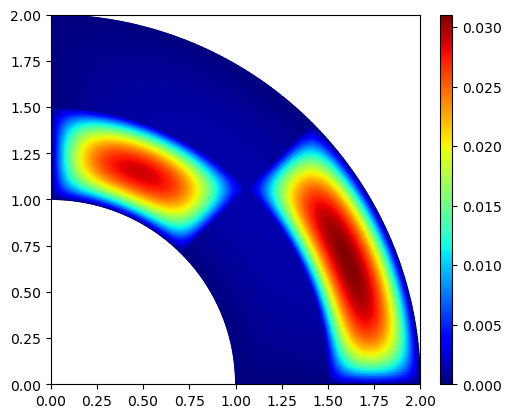

In [475]:
MP.plot(u)

In [189]:
u_delta

[array([0.02488, 0.04895, 0.06182, 0.06291, 0.04005, 0.08725, 0.10785, 0.10665, 0.04571, 0.09821, 0.12132, 0.11922, 0.04415, 0.09915, 0.12082, 0.11903]),
 array([0.08831, 0.13166, 0.07392, 0.08854, 0.13159, 0.07458, 0.07792, 0.11792, 0.0677 , 0.04496, 0.06725, 0.05159]),
 array([0.06291, 0.0641 , 0.05425, 0.02724, 0.10665, 0.10545, 0.08049, 0.03351, 0.11922, 0.11716, 0.08889, 0.03731, 0.11903, 0.11723, 0.08836, 0.03696])]

In [183]:
IMap.BCRestr[0].complete(u_delta[0]+primal.Psi[0]@u_delta[-1])

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.02488, 0.04895, 0.06182, 0.06291, 0.     , 0.04005, 0.08725, 0.10785, 0.10665, 0.     , 0.04571, 0.09821, 0.12132, 0.11922, 0.     , 0.04415, 0.09915, 0.12082, 0.11903])

In [179]:
primal.Psi[0]@u_delta[-1]

array([ 0.00087,  0.0021 ,  0.004  , -0.00109,  0.0032 ,  0.00771,  0.00802,  0.01712,  0.00917,  0.02501,  0.03814,  0.01493,  0.00923,  0.02982,  0.06195,  0.11903])

In [94]:
A[1].toarray()

array([[ 1.34584, -0.27803, -0.24474, -0.34134,  0.     ,  0.     ,  0.5    ],
       [-0.27803,  1.40657, -0.34134, -0.03021,  0.     ,  0.     ,  0.5    ],
       [-0.24474, -0.34134,  2.68751, -0.53556, -0.28116, -0.339  ,  0.     ],
       [-0.34134, -0.03021, -0.53556,  2.7975 , -0.339  , -0.06528,  0.     ],
       [ 0.     ,  0.     , -0.28116, -0.339  ,  2.68075, -0.47731,  0.     ],
       [ 0.     ,  0.     , -0.339  , -0.06528, -0.47731,  2.7577 ,  0.     ],
       [ 0.5    ,  0.5    ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

In [21]:
B = IMap.ConstraintMatrices(redundant=True)

In [22]:
scipy.sparse.hstack(B).toarray()

array([[ 0. ,  0. ,  1. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. , -1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ]])

In [17]:
IMap.B[:,IMap.global_free].toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ]])

In [650]:
print(B[3,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 16)>
  Coords	Values
  (0, 8)	1.0
  (0, 1)	-1.0


In [641]:
B

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 36)>

In [637]:
B[:,IMap.global_free]

array([[ 0. ,  0. ,  1. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. , -1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ]])

In [612]:
corner_idx = np.ones(IMap.numdofs) 
corner_idx[IMap.corners]=0
Q = scipy.sparse.spdiags(corner_idx, 0, IMap.numdofs, IMap.numdofs)

In [613]:
(IMap.B@Q).toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,

In [607]:
IMap.corners

array([ 0,  2,  6,  8,  9, 11, 15, 17, 18, 20, 24, 26])

In [603]:
B =IMap.ConstraintMatrices(redundant=True)

In [600]:
scipy.sparse.hstack(B).toarray()

array([[ 0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [590]:
IMap.B.toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.